# Project 3 - Regression Challenge <br>
## Thomas Brewer - BOS

In [21]:
# Import libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, Imputer

In [83]:
def load_data():
    # Load training data
    train = pd.read_csv('../data/train.csv')

    # Replace spaces with underscores in column names
    train.columns = [c.replace(' ', '_') for c in train.columns]
    return train

train = load_data()

In [84]:
print(train.shape)

(2051, 82)


### Preprocessing

In [87]:
def make_clean() :
    train = load_data()
    
    # Pool
    train['has_pool'] = train['Pool_Area'].apply(lambda x: 0 if x == 0.0 else 1)
    train.drop(['Pool_Area', 'Pool_QC'], axis=1, inplace=True)
    
    # Fence 
    train['Fence'].fillna('None', inplace=True)
    train['has_fence'] = train['Fence'].apply(lambda x: 1 if x == 'None' else 0)
    train.drop(['Fence'], axis=1, inplace=True)

    return train

In [91]:
# Pools caught my attention, so I'll start there :
print(train['Pool_QC'].value_counts())

# Only 9 houses with pool.  I think it might have some effect on SalePrice,
# but I don't think we have enough data to say anything with statistical significance.
# So let's just include a bool column : has_pool, and drop the other Pool related columns. 
# (Probably Won't use it in the end though)
train['has_pool'] = train['Pool_Area'].apply(lambda x: 0 if x == 0.0 else 1)
train.drop(['Pool_Area', 'Pool_QC'], axis=1, inplace=True)

sns.barplot(x='has_pool', y='SalePrice', data=train)

KeyError: 'Pool_QC'

None     1651
MnPrv     227
GdPrv      83
GdWo       80
MnWw       10
Name: Fence, dtype: int64


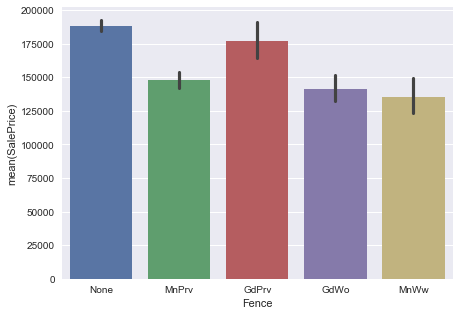

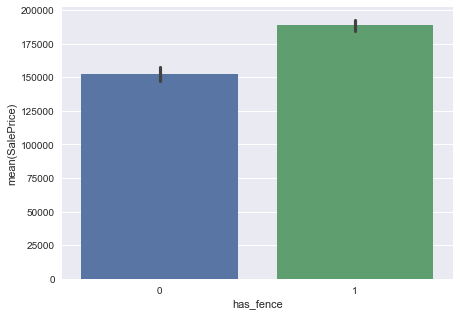

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Screen_Porch,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,has_pool,has_fence
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,0,3,2010,WD,Normal,130500,0,1
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,0,4,2009,WD,Normal,220000,0,1
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,0,1,2010,WD,Abnorml,109000,0,1
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,NaN,0,4,2010,WD,Normal,174000,0,1
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,NaN,0,3,2010,WD,Normal,138500,0,1


In [90]:
# Fences : 
train = load_data()
train['Fence'].fillna('None', inplace=True)
print(train['Fence'].value_counts())

f, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x='Fence', y='SalePrice', data=train, ax=ax)
plt.show()

# Seems like most properties don't have a fence, but the spread on it seems low.
# Like for the pool, I'll just make a has_fence column.  May or may not be useful.
train['has_fence'] = train['Fence'].apply(lambda x: 1 if x == 'None' else 0)
train.drop(['Fence'], axis=1, inplace=True)

f, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x='has_fence', y='SalePrice', data=train, ax=ax)
plt.show()

train = make_clean()
train.head()

Normal     1696
Partial     164
Abnorml     132
Family       29
Alloca       19
AdjLand      11
Name: Sale_Condition, dtype: int64


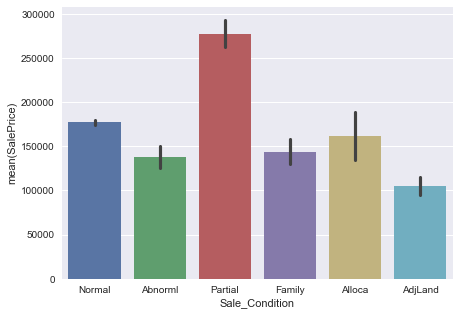

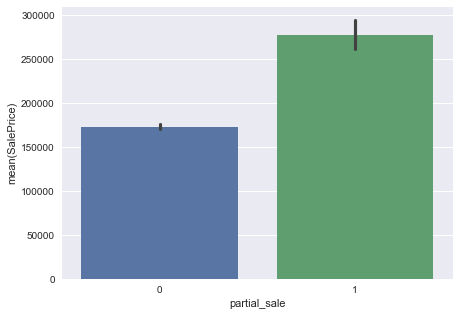

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Screen_Porch,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,SalePrice,has_pool,has_fence,partial_sale
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,0,3,2010,WD,130500,0,1,0
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,0,4,2009,WD,220000,0,1,0
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,0,1,2010,WD,109000,0,1,0
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,NaN,0,4,2010,WD,174000,0,1,0
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,NaN,0,3,2010,WD,138500,0,1,0


In [96]:
train = make_clean()

# Sale Condition
print(train['Sale_Condition'].value_counts())

f, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x='Sale_Condition', y='SalePrice', data=train, ax=ax)
plt.show()

# Seems like PartialSale is what has biggest effect on sale price, make bool col : partial_sale
train['partial_sale'] = train['Sale_Condition'].apply(lambda x: 1 if x == 'Partial' else 0)
train.drop('Sale_Condition', axis=1, inplace=True)

f, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x='partial_sale', y='SalePrice', data=train, ax=ax)
plt.show()

train.head()

## EDA

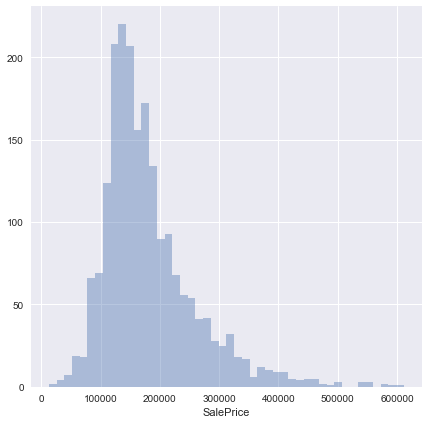

In [58]:
f, ax = plt.subplots(figsize=(7, 7))
sns.distplot(train['Fence'], kde=False, ax=ax)